In [1]:
#!pip install findspark

In [65]:
import findspark
findspark.init("C:\spark")

In [66]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("big_data_churn_modellemesi") \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local appName=big_data_churn_modellemesi>

In [67]:
?sc

Type:        SparkContext
String form: <SparkContext master=local appName=big_data_churn_modellemesi>
File:        c:\spark\python\pyspark\context.py
Docstring:  
Main entry point for Spark functionality. A SparkContext represents the
connection to a Spark cluster, and can be used to create :class:`RDD` and
broadcast variables on that cluster.

When you create a new SparkContext, at least the master and app name should
be set, either through the named parameters here or through `conf`.

Parameters
----------
master : str, optional
    Cluster URL to connect to (e.g. mesos://host:port, spark://host:port, local[4]).
appName : str, optional
    A name for your job, to display on the cluster web UI.
sparkHome : str, optional
    Location where Spark is installed on cluster nodes.
pyFiles : list, optional
    Collection of .zip or .py files to send to the cluster
    and add to PYTHONPATH.  These can be paths on the local file
    system or HDFS, HTTP, HTTPS, or FTP URLs.
environment : dict

In [68]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
+--------+---------+-----------+



In [69]:
spark_df = spark.read.csv("churn.csv", 
                          header = True, 
                          inferSchema = True,
                          sep = ",")
spark_df.cache()

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [70]:
spark_df.show(3)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [71]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [72]:
spark_df = spark_df.withColumnRenamed("_c0", "index")

In [73]:
spark_df.count()

900

In [74]:
spark_df.distinct().count()

900

In [75]:
print(spark_df.describe().show())

+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|             index|        Names|              Age|   Total_Purchase|   Account_Manager|            Years|         Num_Sites|              Churn|
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               900|          900|              900|              900|               900|              900|               900|                900|
|   mean|             449.5|         null|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|259.95191863111916|         null|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|                 0|   Aaron King|             22.0|          

In [76]:
spark_df.select("age","total_purchase", "account_manager", "years","num_sites","churn").describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


In [77]:
spark_df.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [78]:
spark_df.groupby("churn").agg({"total_purchase": "mean"}).show()

+-----+-------------------+
|churn|avg(total_purchase)|
+-----+-------------------+
|    1| 10192.179933333337|
|    0| 10036.952853333332|
+-----+-------------------+



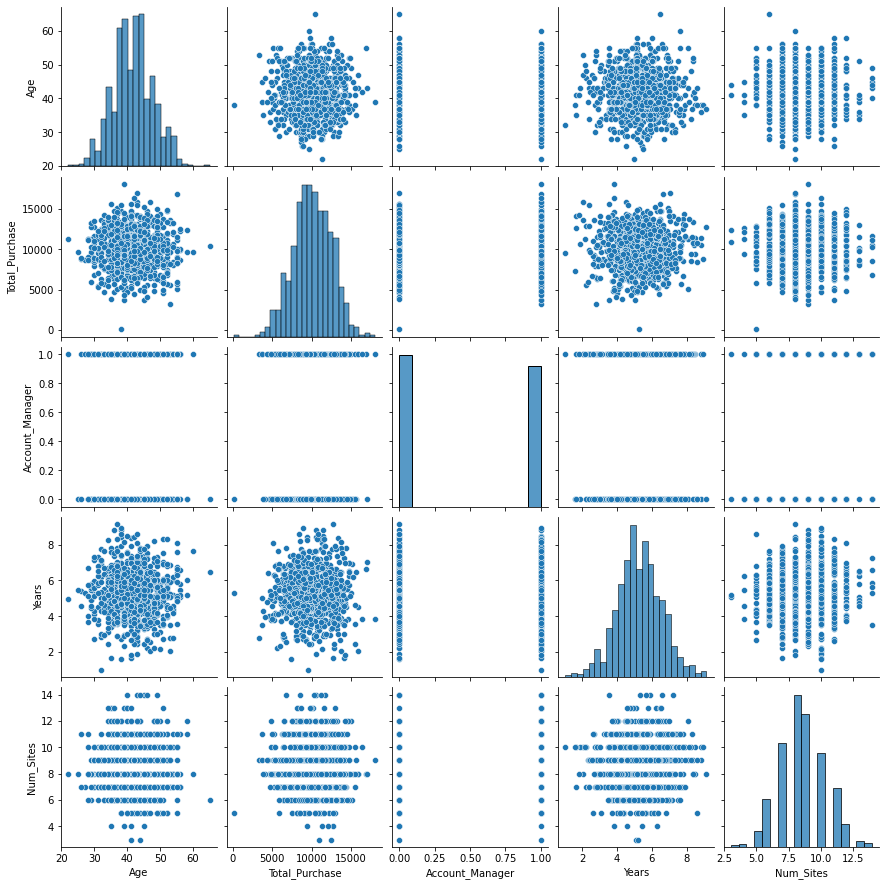

In [79]:
corr_data = spark_df.drop("index","Names","Churn").toPandas()
import seaborn as sns
sns.pairplot(corr_data);

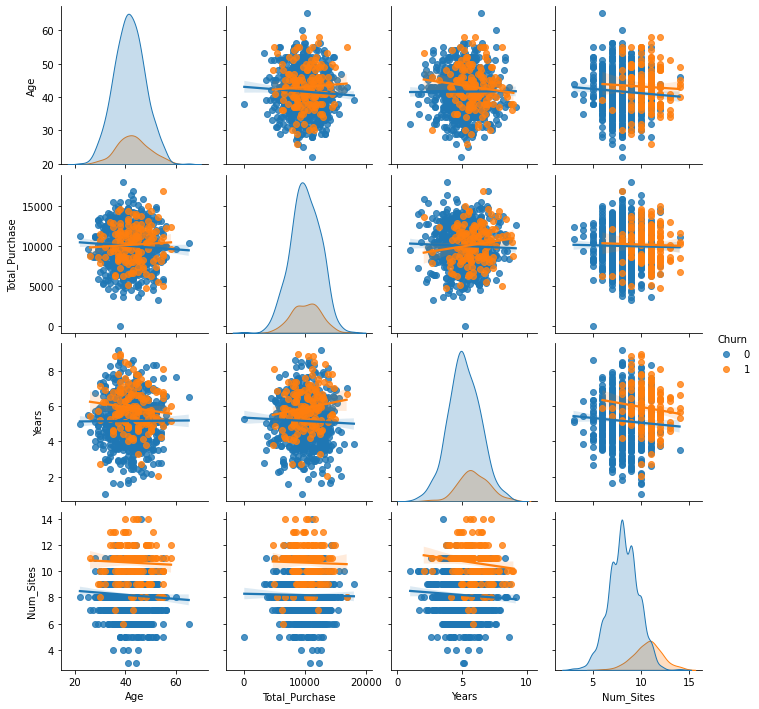

In [80]:
corr_data_ = spark_df.drop("index","Names").toPandas()
sns.pairplot(corr_data_, vars = ["Age", "Total_Purchase","Years","Num_Sites"], 
             hue = "Churn",
            kind = "reg");

In [81]:
pd_df = spark_df.toPandas()
pd_df.drop(columns=["index", "Names"], inplace=True)
pd_df

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,42.0,11066.80,0,7.22,8.0,1
1,41.0,11916.22,0,6.50,11.0,1
2,38.0,12884.75,0,6.67,12.0,1
3,42.0,8010.76,0,6.71,10.0,1
4,37.0,9191.58,0,5.56,9.0,1
...,...,...,...,...,...,...
895,42.0,12800.82,1,3.62,8.0,0
896,52.0,9893.92,0,6.91,7.0,0
897,45.0,12056.18,0,5.46,4.0,0
898,51.0,6517.93,1,5.47,10.0,0


In [82]:
pd_df.columns = map(str.lower, pd_df.columns)

In [83]:
pd_df.dtypes

age                float64
total_purchase     float64
account_manager      int32
years              float64
num_sites          float64
churn                int32
dtype: object

In [84]:
pd_df["account_manager"] = pd_df["account_manager"].astype("object")
pd_df["churn"] = pd_df["churn"].astype("object") #for now: !!!!!!!!!

In [85]:
import numpy as np
pd_df.select_dtypes(include=np.number).columns

Index(['age', 'total_purchase', 'years', 'num_sites'], dtype='object')

In [86]:
my_dict= {}
def find_IQR(df):
    for column in df.select_dtypes(include=np.number).columns:
        Q1 =  df[column].quantile(0.25)
        Q3 =  df[column].quantile(0.75)
        IQR = Q3-Q1
        lower_level = Q1- 1.5*IQR
        upper_level = Q3 + 1.5*IQR
        my_dict[column] = {lower_level, upper_level}
    
    return my_dict

In [87]:
IQR_results = find_IQR(pd_df)

In [88]:
IQR_results

{'age': {26.0, 58.0},
 'total_purchase': {3602.648750000004, 16654.578749999997},
 'years': {1.96, 8.600000000000001},
 'num_sites': {2.5, 14.5}}

In [91]:
def suppression_method(df, IQR_results):
    for i in range(len(IQR_results.keys())):
        key = list(IQR_results.keys())[i]
        for j in range(len(df)):
            if df[key][j] < list(IQR_results[key])[0]:
                df[key][j] = list(IQR_results[key])[0]
                
            elif df[key][j] > list(IQR_results[key])[1]:
                df[key][j] = list(IQR_results[key])[1]
                
    return df

In [92]:
suppression_method(pd_df, IQR_results)

<ipython-input-91-71b58506fcf4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key][j] = list(IQR_results[key])[1]
<ipython-input-91-71b58506fcf4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key][j] = list(IQR_results[key])[0]


,age,total_purchase,account_manager,years,num_sites,churn
0,42.0,11066.80,0,8.6,8.0,1
1,41.0,11916.22,0,8.6,11.0,1
2,38.0,12884.75,0,8.6,12.0,1
3,42.0,8010.76,0,8.6,10.0,1
4,37.0,9191.58,0,8.6,9.0,1
...,...,...,...,...,...,...
895,42.0,12800.82,1,8.6,8.0,0
896,52.0,9893.92,0,8.6,7.0,0
897,45.0,12056.18,0,8.6,4.0,0
898,51.0,6517.93,1,8.6,10.0,0


In [93]:
pd_df.filter(pd_df.age > 58).count() #we successed!

Series([], dtype: int64)

In [94]:
pd_df.filter(pd_df["total_purchase"] > 16654.5).count() #we successed!

Series([], dtype: int64)

In [95]:
#I converted to spark data frame:

In [96]:
spark_df=spark.createDataFrame(pd_df) 
spark_df.printSchema()
spark_df.show()

root
 |-- age: double (nullable = true)
 |-- total_purchase: double (nullable = true)
 |-- account_manager: long (nullable = true)
 |-- years: double (nullable = true)
 |-- num_sites: double (nullable = true)
 |-- churn: long (nullable = true)

+----+--------------+---------------+-----------------+---------+-----+
| age|total_purchase|account_manager|            years|num_sites|churn|
+----+--------------+---------------+-----------------+---------+-----+
|42.0|       11066.8|              0|8.600000000000001|      8.0|    1|
|41.0|      11916.22|              0|8.600000000000001|     11.0|    1|
|38.0|      12884.75|              0|8.600000000000001|     12.0|    1|
|42.0|       8010.76|              0|8.600000000000001|     10.0|    1|
|37.0|       9191.58|              0|8.600000000000001|      9.0|    1|
|48.0|      10356.02|              0|8.600000000000001|      8.0|    1|
|44.0|      11331.58|              1|8.600000000000001|     11.0|    1|
|32.0|       9885.12|              

In [97]:
spark_df.filter(spark_df["total_purchase"] > 16654.578749999997).show()

+---+--------------+---------------+-----+---------+-----+
|age|total_purchase|account_manager|years|num_sites|churn|
+---+--------------+---------------+-----+---------+-----+
+---+--------------+---------------+-----+---------+-----+



In [99]:
#The setting independent variables:

In [100]:
from pyspark.ml.feature import VectorAssembler
def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized


In [101]:
vect_spark_df = vectorizerFunction(spark_df, "churn")
vect_spark_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
+--------------------+-----+
only showing top 5 rows



## Elimination of class imbalance by oversampling with the Smote algorithm:

In [102]:
from pyspark.sql import Row
from sklearn import neighbors
import numpy as np
import random

def smoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = int(percentageOver/100)
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)

In [103]:
smote_sampling_df = smoteSampling(vect_spark_df, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100)

In [104]:
smote_sampling_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  750|
|    1|  450|
+-----+-----+



In [105]:
#To split train-test:

In [106]:
splits = smote_sampling_df.randomSplit([0.7,0.3])
train_df = splits[0]
test_df = splits[1]

train_df_x = train_df.select("features")
train_df_y = train_df.select("label")
test_df_x = test_df.select("features")
test_df_y = test_df.select("label")

In [107]:
train_df.select("label").count()

825

In [108]:
#Machine Learning Part (Classification):

## Logistic Regression

In [126]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)
y_pred = lr_model.transform(test_df) 
y_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[26.0,8939.61,0.0...|    0|[0.58174163848783...|[0.64146805879105...|       0.0|
|[26.0,9672.03,0.0...|    0|[0.54550190546528...|[0.63309137042417...|       0.0|
|[28.0,11128.95,1....|    0|[0.54550190546528...|[0.63309137042417...|       0.0|
|[28.0,11204.23,0....|    0|[0.43678270639766...|[0.60749214763929...|       0.0|
|[28.0,11245.38,0....|    0|[0.54550190546528...|[0.63309137042417...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [127]:
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count() 

0.6133333333333333

In [131]:
trainingSummary = lr_model.summary
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.001923076923076...|0.013114754098360656|
|0.001923076923076...| 0.01639344262295082|
|0.001923076923076...|0.019672131147540985|
|0.001923076923076...| 0.03278688524590164|
|0.001923076923076...|0.036065573770491806|
|0.001923076923076...| 0.03934426229508197|
|0.001923076923076...| 0.04262295081967213|
|0.001923076923076...| 0.04590163934426229|
|0.001923076923076...| 0.04918032786885246|
|0.001923076923076...| 0.05245901639344262|
|0.001923076923076...| 0.05573770491803279|
|0.001923076923076...| 0.05901639344262295|
|0.001923076923076...| 0.06229508196721312|
|0.001923076923076...| 0.06557377049180328|
|0.009615384615384616|  0.1540983606557377|
|0.009615384615384616| 0.15737704918032788|
|0.009615384615384616| 0.16065573770491803|
|0.009615384615384616| 0.16393442622950818|
|0.009615384615384616| 0.1672131

In [139]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, np.arange(0, .1, .01))
             .addGrid(lr.elasticNetParam, [0, 1])
             .build())

cv = CrossValidator(estimator= lr, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds= 10)
cv_model = cv.fit(train_df)
y_pred = cv_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8053333333333333

### Random Forest (RF):

In [123]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=10, featuresCol="features", labelCol="label")
rf_model = rf.fit(train_df)
y_pred = rf_model.transform(test_df) 
y_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[26.0,8939.61,0.0...|    0|[9.51448113821942...|[0.95144811382194...|       0.0|
|[26.0,9672.03,0.0...|    0|[9.42648113821942...|[0.94264811382194...|       0.0|
|[28.0,11128.95,1....|    0|[9.44624290827968...|[0.94462429082796...|       0.0|
|[28.0,11204.23,0....|    0|[6.91528092227631...|[0.69152809222763...|       0.0|
|[28.0,11245.38,0....|    0|[9.42648113821942...|[0.94264811382194...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [124]:
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count() 

0.88

In [133]:
trainingSummary_ = rf_model.summary
trainingSummary_.roc.show()
print("areaUnderROC: " + str(trainingSummary_.areaUnderROC))

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.009836065573770493|
|0.0| 0.01639344262295082|
|0.0|0.019672131147540985|
|0.0| 0.04262295081967213|
|0.0| 0.04918032786885246|
|0.0| 0.12131147540983607|
|0.0|                 0.2|
|0.0| 0.20655737704918034|
|0.0|  0.2098360655737705|
|0.0| 0.21639344262295082|
|0.0| 0.21967213114754097|
|0.0| 0.22950819672131148|
|0.0|  0.2360655737704918|
|0.0| 0.24918032786885247|
|0.0| 0.25245901639344265|
|0.0| 0.25901639344262295|
|0.0| 0.28852459016393445|
|0.0| 0.36065573770491804|
|0.0|  0.3704918032786885|
+---+--------------------+
only showing top 20 rows

areaUnderROC: 0.9592276166456495


In [140]:
# Number of trees in random forest
n_estimators = [10, 100, 500]

# Number of features to consider at every split
max_depth = [10, 20, 30]

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)])
             .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)])
             .build())

              
cv = CrossValidator(estimator= rf, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds= 10)
cv_model = cv.fit(train_df)
y_pred = cv_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.896